In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///C:/Users/board/sqlalchemy-challenge/Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
# List all of the classes mapped by automap
all_classes = Base.classes.keys()
print(all_classes)

['station', 'measurement']


In [9]:
# Save references to each table
# Access mapped classes using automap_base
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
from sqlalchemy import desc

# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
print("Most recent date:", most_recent_date[0])

Most recent date: 2017-08-23


In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
from datetime import datetime, timedelta
from sqlalchemy import func

In [27]:
# Starting from the most recent data point in the database. 
import datetime as dt
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
import pandas as pd

# Sort the dataframe by date
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.pyplot as plt

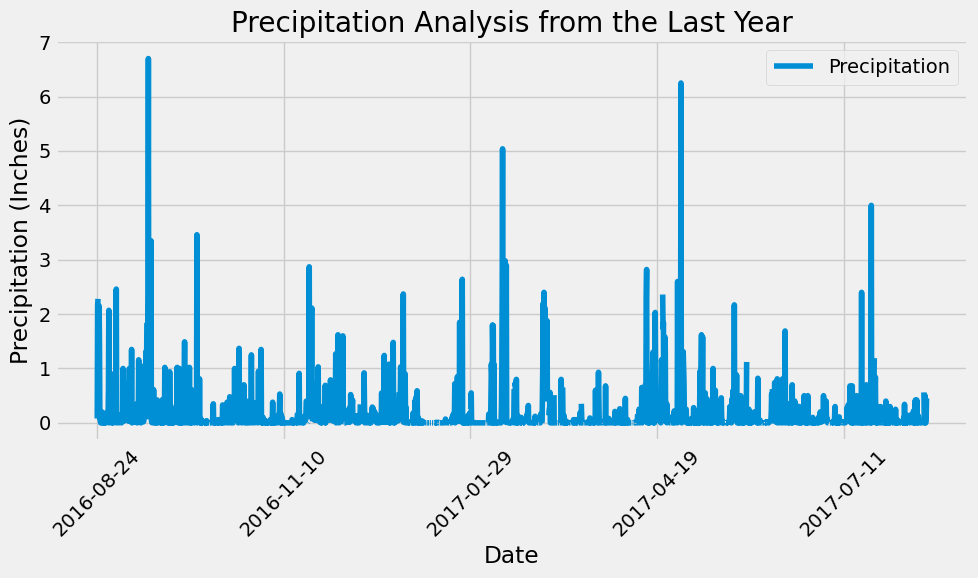

In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.plot(x='Date', y='Precipitation', title='Precipitation Analysis from the Last Year',
        figsize=(10, 6), legend=True)
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Exploratory Station Analysis

In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


In [30]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print("Total number of stations in the dataset:", total_stations)


Total number of stations in the dataset: 9


In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
    
for station, count in most_active_stations:
    print(f"Station {station} has {count} observations")

Station USC00519281 has 2772 observations
Station USC00519397 has 2724 observations
Station USC00513117 has 2709 observations
Station USC00519523 has 2669 observations
Station USC00516128 has 2612 observations
Station USC00514830 has 2202 observations
Station USC00511918 has 1979 observations
Station USC00517948 has 1372 observations
Station USC00518838 has 511 observations


In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

In [33]:
# Using the most active station id
temperature_stats_with_name = session.query(
    Station.name,
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).join(Station, Measurement.station == Station.station).\
    filter(Measurement.station == most_active_station_id).\
    group_by(Station.name).\
    one()

station_name, lowest_temp, highest_temp, avg_temp = temperature_stats_with_name

print(f"Station Name: {station_name}")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Station Name: WAIHEE 837.5, HI US
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


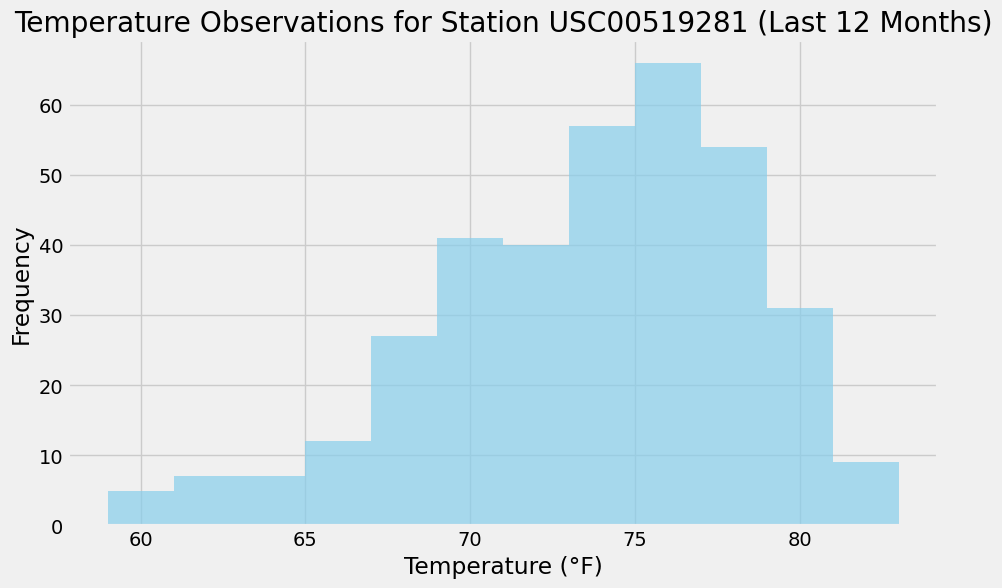

In [34]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Get the most recent date in the database for the most active station
last_date = session.query(func.max(Measurement.date)).\
    filter(Measurement.station == most_active_station_id).scalar()
last_date = datetime.strptime(last_date, '%Y-%m-%d')

# Calculate the date one year from the last date in the dataset
start_date = last_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for this station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= start_date).all()

# Extract temperature observations as a list
temperatures = [temp[0] for temp in temperature_data]

### Step: Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, color='skyblue', alpha=0.7)
plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [35]:
# Close Session
session.close()